# Question 4:

### *Does time of year (month or season) affect the amount of each category that is ordered? Need to account for North/South Hemisphere & Tropical regions with no winters.*

OR

*Does the supplier country influence how well a product sells in a particular region? (more precisely: is the performance of a product generally better/worse if the customer and supplier are from the same country/region?)*


<br><br><br>


## Define Hypotheses

For this, we first need to define our hypotheses:
<br>
<br>
    ***Null Hypothesis:*** 
<br>
    ***Alternate Hypothesis:*** 

For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Data & Libraries

In [37]:
# For SQL & dataframes
import pandas as pd
import sqlite3

# For math & statistics
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


In [3]:
c.execute("""
          SELECT p.ProductName, cat.CategoryName, s.Region as SupplierRegion,
          od.Quantity as Units, (od.Quantity*od.UnitPrice) as OrderPrice, o.OrderDate,
          o.ShipRegion as CustomerRegion, o.ShipCountry as CustomerCountry
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          ORDER BY 1;
          """)

df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    df.replace(i, 'Australia', inplace=True)

display(df.head())
df.info()

,ProductName,CategoryName,SupplierRegion,Units,OrderPrice,OrderDate,CustomerRegion,CustomerCountry
0,Alice Mutton,Meat/Poultry,Australia,30,936.0,2012-07-25,Western Europe,France
1,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-13,Western Europe,Germany
2,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-30,North America,USA
3,Alice Mutton,Meat/Poultry,Australia,40,1248.0,2012-09-10,Western Europe,Belgium
4,Alice Mutton,Meat/Poultry,Australia,8,249.6,2012-10-02,Latin America,Mexico


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
ProductName        2155 non-null object
CategoryName       2155 non-null object
SupplierRegion     2155 non-null object
Units              2155 non-null int64
OrderPrice         2155 non-null float64
OrderDate          2155 non-null object
CustomerRegion     2155 non-null object
CustomerCountry    2155 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 134.8+ KB


In [4]:
c.execute("""
          SELECT p.ProductName, cat.CategoryName, s.Region as SupplierRegion, o.ShipRegion as CustomerRegion,
          SUM(od.Quantity) as TotalUnits, SUM(od.Quantity*od.UnitPrice) as TotalPrice
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          GROUP BY 1,2,3,4
          ORDER BY 1,4;
          """)

prod_totals_df = pd.DataFrame(c.fetchall())
prod_totals_df.columns = [x[0] for x in c.description]
for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    prod_totals_df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    prod_totals_df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    prod_totals_df.replace(i, 'Australia', inplace=True)
prod_totals_df = (prod_totals_df.groupby(['ProductName','CategoryName','SupplierRegion','CustomerRegion'])
                  .sum().reset_index(drop=True))

display(prod_totals_df.head(10))
prod_totals_df.info()

,TotalUnits,TotalPrice
0,25,975.0
1,63,2394.6
2,487,17487.6
3,10,312.0
4,80,3120.0
5,313,11193.0
6,30,240.0
7,70,560.0
8,24,240.0
9,44,440.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 2 columns):
TotalUnits    426 non-null int64
TotalPrice    426 non-null float64
dtypes: float64(1), int64(1)
memory usage: 6.7 KB


In [5]:
c.execute("""
          SELECT s.Region as SupplierRegion, o.ShipRegion as CustomerRegion,
          SUM(od.Quantity) as TotalUnits, SUM(od.Quantity*od.UnitPrice) as TotalPrice
          FROM OrderDetail od
          JOIN 'Order' o  ON od.OrderId = o.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON cat.Id = p.CategoryId
          JOIN Supplier s ON p.SupplierId = s.Id
          GROUP BY 1,2
          ORDER BY 1,3 desc,2;
          """)

regions_df = pd.DataFrame(c.fetchall())
regions_df.columns = [x[0] for x in c.description]
for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    regions_df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    regions_df.replace(i, 'Latin America', inplace=True)
for i in ['Victoria', 'NSW']:
    regions_df.replace(i, 'Australia', inplace=True)
regions_df = (regions_df.groupby(['SupplierRegion', 'CustomerRegion']).sum()
              .sort_values(by=['SupplierRegion','TotalUnits'], ascending=[True, False])
              .reset_index(drop=True))
display(regions_df)
regions_df.info()

,TotalUnits,TotalPrice
0,2276,73951.35
1,1439,45972.10
2,1002,26271.90
3,583,15073.60
4,455,14786.50
5,290,8967.20
6,1921,32836.10
7,1262,19282.70
8,896,13873.40
9,490,7580.70


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
TotalUnits    54 non-null int64
TotalPrice    54 non-null float64
dtypes: float64(1), int64(1)
memory usage: 944.0 bytes


In [6]:
df.head()

,ProductName,CategoryName,SupplierRegion,Units,OrderPrice,OrderDate,CustomerRegion,CustomerCountry
0,Alice Mutton,Meat/Poultry,Australia,30,936.0,2012-07-25,Western Europe,France
1,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-13,Western Europe,Germany
2,Alice Mutton,Meat/Poultry,Australia,15,468.0,2012-08-30,North America,USA
3,Alice Mutton,Meat/Poultry,Australia,40,1248.0,2012-09-10,Western Europe,Belgium
4,Alice Mutton,Meat/Poultry,Australia,8,249.6,2012-10-02,Latin America,Mexico


### Graph product category popularity by month in terms of total dollars spent 




In [7]:
# look at the percentile breakdown of the OrderPrice 
# data to determine where to cut off outliers
for q in np.linspace(.9, 1, num=11):
    aq =  round(df.OrderPrice.quantile(q=q), 2)
    print('{}th percentile:\tset1: {}'.format(round(q,2), aq))

0.9th percentile:	set1: 1366.8
0.91th percentile:	set1: 1440.0
0.92th percentile:	set1: 1551.36
0.93th percentile:	set1: 1620.0
0.94th percentile:	set1: 1742.28
0.95th percentile:	set1: 1968.84
0.96th percentile:	set1: 2200.0
0.97th percentile:	set1: 2475.3
0.98th percentile:	set1: 3073.84
0.99th percentile:	set1: 4637.48
1.0th percentile:	set1: 15810.0


In [8]:
# Remove days from the dates (so can group by month)
df1 = df.copy()
df1.OrderDate = df1.OrderDate.map(lambda x: x[:-3])

# Remove Outliers from OrderPrice data
df1 = df1.loc[df1.OrderPrice < 1750]

# Remove final month, which only recorded 6 days
df1 = df1.loc[df1['OrderDate'] < '2014-05']

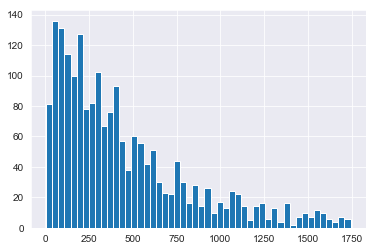

In [9]:
# Look at the distribution of prices, just in case
plt.hist(df1.OrderPrice, bins=50);

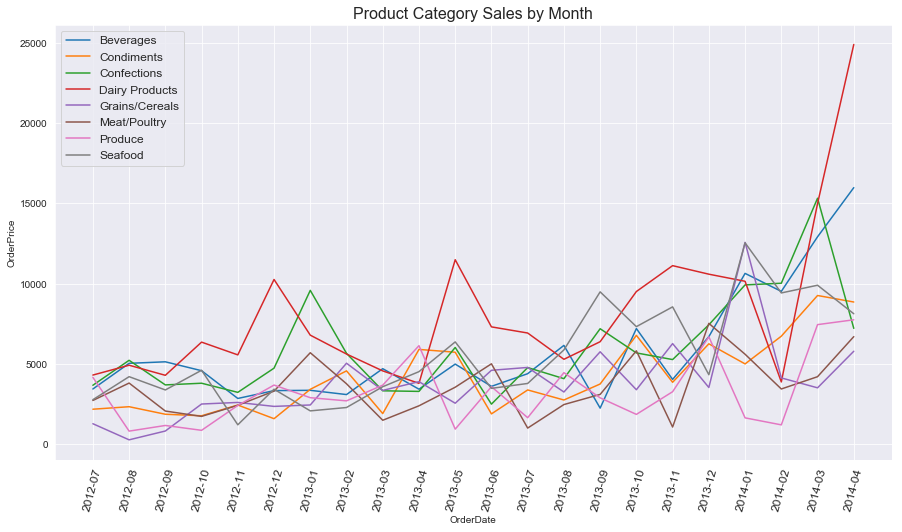

In [10]:
df2 = pd.DataFrame(df1.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                   .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))
df2.head()

# Plot trends
plt.figure(figsize=(15,8))
plt.title('Product Category Sales by Month', fontsize=16)
for i in list(df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=df2.loc[df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

In [11]:
# Splitting data by Latitudinal climate regions
north_df = df1.loc[~df1.CustomerCountry.isin(['Mexico','Venezuela','Brazil','Argentina'])].reset_index(drop=True)
tropic_df = df1.loc[df1.CustomerCountry.isin(['Mexico','Venezuela','Brazil'])].reset_index(drop=True)
south_df = df1.loc[df1.CustomerCountry == 'Argentina'].reset_index(drop=True)

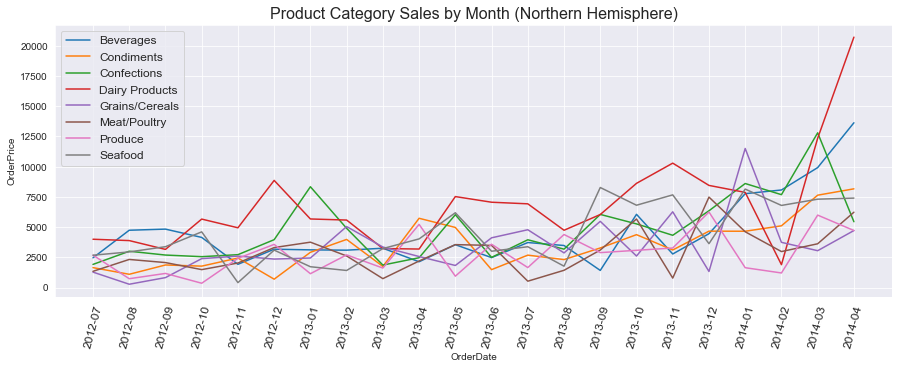

In [31]:
# Plotting only Northern Hemisphere observations, in order to remove
# potentially confounding influence of regions experiencing different seasons
north_df2 = pd.DataFrame(north_df.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))

# Plot trends
plt.figure(figsize=(15,5))
plt.title('Product Category Sales by Month (Northern Hemisphere)', fontsize=16)
for i in list(north_df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=north_df2.loc[north_df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

#### Group by season

In [22]:
season_df = north_df2.copy()
# winter = ['-01','-02','-03']
# spring = ['-04','-05','-06']
# summer = ['-07','-08','-09']
# autumn = ['-10','-11','-12']
# seasons = ['Winter','Spring','Summer','Autumn']
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-01', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-02', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-03', 'aWinter'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-04', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-05', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-06', 'bSpring'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-07', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-08', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-09', 'cSummer'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-10', 'dAutumn'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-11', 'dAutumn'))
season_df.OrderDate = season_df.OrderDate.map(lambda x: x.replace('-12', 'dAutumn'))

season_df2 = pd.DataFrame(season_df.groupby(['OrderDate', 'CategoryName'], as_index=False).sum()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))

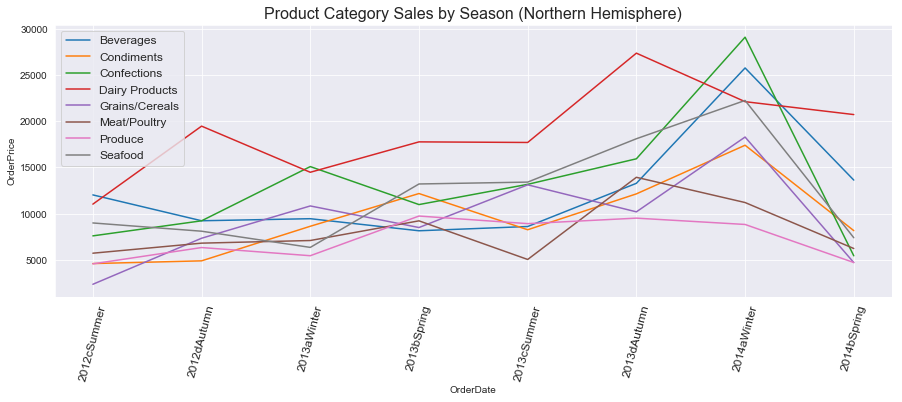

In [30]:
plt.figure(figsize=(15,5))
plt.title('Product Category Sales by Season (Northern Hemisphere)', fontsize=16)
for i in list(season_df2.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=season_df2.loc[season_df2.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

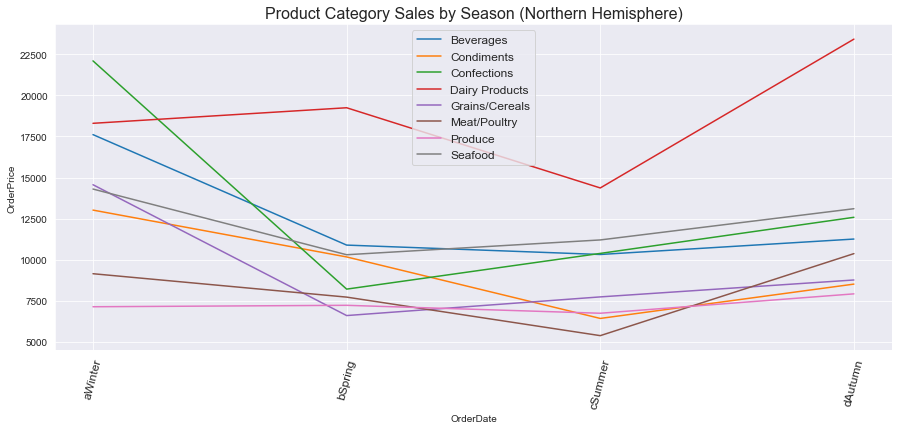

In [33]:
# Now to average our data by season
season_df3 = season_df2.copy()
season_df3.OrderDate = season_df3.OrderDate.map(lambda x: x[-7:])
season_df4 = pd.DataFrame(season_df3.groupby(['OrderDate', 'CategoryName'], as_index=False).mean()
                         .sort_values(['CategoryName','OrderDate']).reset_index(drop=True))

# Plotting, once again
plt.figure(figsize=(15,6))
plt.title('Product Category Sales by Season (Northern Hemisphere)', fontsize=16)
for i in list(season_df4.CategoryName.unique()):
    sns.lineplot(x='OrderDate', y='OrderPrice', data=season_df4.loc[season_df4.CategoryName == i], label=i)
plt.legend(fontsize=12)
plt.xticks(rotation=75, fontsize=12);

In [35]:
season_df4.head()

,OrderDate,CategoryName,Units,OrderPrice
0,aWinter,Beverages,1233.5,17608.425
1,bSpring,Beverages,710.0,10891.500
2,cSummer,Beverages,662.5,10320.425
3,dAutumn,Beverages,737.5,11258.725
4,aWinter,Condiments,626.5,13019.250


In [44]:
def create_sample_distribution(data, dist_size=1000, n=30):
    """
    Inputs:
    - data : original dataset
    - dist_size : number of samples to generate
    - n : size of each sample
    =======================
    Returns:
    - sample distribution of sample means
    """
    sample_distr = []
    for i in range(0,dist_size):
        sample = []
        i_list = list(np.random.randint(0,len(data),n))
        for item in i_list:
            sample.append(data[item])
        sample_distr.append(np.mean(sample))
    return sample_distr


def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = np.mean(a) - np.mean(b)
    denominator = np.sqrt(np.var(a, ddof=1)/len(a) + np.var(b, ddof=1)/np.size(b))
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (np.var(a, ddof=1)/np.size(a) + np.var(b, ddof=1)/np.size(b))**2
    denom = (((np.var(a, ddof=1)**2) / (((np.size(a))**2) * (np.size(a)-1)))
             + ((np.var(b, ddof=1)**2) / (((np.size(b))**2) * (np.size(b)-1))))
    return num/denom


def p_value(a, b, two_sided=False):
    """
    Returns the p-value from a Welch's t-test given two datasets (lists, arrays, or series).
    """
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p

In [50]:
seasons = []
cats = []
ord_pr = []
ordp = []
for season in list(season_df4.OrderDate.values):
    for cat in list(season_df4.CategoryName.values):
        for i in range(0,1000):
            seasons.append(season)
            cats.append(cat)
        a1 = list(season_df4.OrderPrice[season_df4.OrderDate == season].values)
        a2 = create_sample_distribution(a1, 1000, 30)
        ordp.append(a2)

for i in ordp:
    for e in i:
        ord_pr.append(e)

In [58]:

# Making a DataFrame of all of our sampling distributions
samps = {}
samps['Season'] = seasons
samps['Category'] = cats
samps['OrderPrice'] = ord_pr
samp_distributions_df = pd.DataFrame(samps)

for i in list(samp_distributions_df.Category.unique()):
    print('\n',i)
    ols_df = samp_distributions_df.loc[samp_distributions_df.Category == i]
    formula = 'OrderPrice ~ C(Season)'
    lm = ols(formula, ols_df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(table,"\n")


 Beverages
                 sum_sq        df              F  PR(>F)
C(Season)  5.569602e+11       3.0  343565.242669     0.0
Residual   6.916559e+10  127996.0            NaN     NaN 


 Condiments
                 sum_sq        df              F  PR(>F)
C(Season)  5.544978e+11       3.0  340989.373581     0.0
Residual   6.937997e+10  127996.0            NaN     NaN 


 Confections
                 sum_sq        df              F  PR(>F)
C(Season)  5.548829e+11       3.0  342413.003481     0.0
Residual   6.913950e+10  127996.0            NaN     NaN 


 Dairy Products
                 sum_sq        df              F  PR(>F)
C(Season)  5.561353e+11       3.0  345003.764944     0.0
Residual   6.877518e+10  127996.0            NaN     NaN 


 Grains/Cereals
                 sum_sq        df              F  PR(>F)
C(Season)  5.548248e+11       3.0  341452.412098     0.0
Residual   6.932675e+10  127996.0            NaN     NaN 


 Meat/Poultry
                 sum_sq        df              